In [1]:
spark

In [2]:
!pip install --upgrade colorama
from pysparkling import *
import h2o
hc = H2OContext.getOrCreate(spark)

  Using cached colorama-0.3.9-py2.py3-none-any.whl
  Found existing installation: colorama 0.3.7
    Uninstalling colorama-0.3.7:
      Successfully uninstalled colorama-0.3.7
[WARNING] H2O requires colorama module of version 0.3.8 or newer. You have version 0.3.7.
You can upgrade to the newest version of the module running from the command line
    $ pip3 install --upgrade colorama
Connecting to H2O server at http://172.17.0.2:54321... successful.


--------------------------  ------------------------------------------
H2O cluster uptime:         04 secs
H2O cluster version:        3.14.0.7
H2O cluster version age:    1 month
H2O cluster name:           sparkling-water-jovyan_local-1511270189716
H2O cluster total nodes:    1
H2O cluster free memory:    10.51 Gb
H2O cluster total cores:    36
H2O cluster allowed cores:  36
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://172.17.0.2:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.3 final
--------------------------  ------------------------------------------


Sparkling Water Context:
 * H2O name: sparkling-water-jovyan_local-1511270189716
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://172.17.0.2:54321 (CMD + click in Mac OSX)

    


In [59]:
import pandas as pd
import numpy as np
import pandas.io.sql as psql
# import pyodbc
import csv
import matplotlib.pyplot as plt
import seaborn as sns

### Seaborn style
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.float_format', lambda x: '{:,.1f}'.format(x))

%matplotlib inline

In [60]:
df = sqlContext.read.parquet('/home/jovyan/work/sparkling-water-2.2.2/data/s3/flight.pq.11.comb')

In [61]:
df.count()

106453155

In [62]:
df_sample = df.sample(False, 0.1, 42)

In [63]:
df_sample.count()

10645075

In [64]:
df = df_sample

In [65]:
import pyspark
from pyspark import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import TimestampType

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import pandas as pd
from sklearn import *
from sklearn import preprocessing
# import lightgbm as lgb
from multiprocessing import *
from sklearn.model_selection import StratifiedKFold


In [66]:
lookforwardDays = 19
ndays = lambda i: i * 86400 # number of seconds in a day
byVar = ['toCity', 'depDate', 'stayDays', 'timeline1_departureTime_time', 'timeline2_departureTime_time',
         'timeline1_carrier_airlineCode', 'timeline2_carrier_airlineCode']

w = (Window.partitionBy('routeCombKey')
     .orderBy(F.col('searchDate').cast('timestamp').cast('long'))
     .rowsBetween(0, ndays(lookforwardDays)))

threshold = 20

udfGetWeekNumer = lambda dt: F.udf(dt.isocalendar()[1], IntegerType())
# udfGetAvg = lambda x: F.udf(sum(x)/float(len(x)))\n\n

df2 = (df.filter(df.price > 0)
       .withColumn('routeCombKey', F.concat_ws('-', F.col('fromCity'),
                                   F.col('toCity'),
                                   F.col('stayDays'), F.col('depDate'),
                                   F.col('timeline1_departureTime_time'),
                                   F.col('timeline2_departureTime_time'),
                                   F.col('timeline1_carrier_airlineCode'),
                                   F.col('timeline2_carrier_airlineCode')))
                                   # join_udf(F.col('timeline1_departureTime_time')),
                                   # join_udf(F.col('timeline2_departureTime_time')),
                                   # join_udf(F.col('timeline1_carrier_airlineCode')),
                                   # join_udf(F.col('timeline2_carrier_airlineCode'))))
       .withColumn('futureMinPrice', F.min(F.col('price')).over(w))
       .withColumn('priceWillDrop', (F.col('price') - F.col('futureMinPrice') > threshold).cast('int'))
       .withColumn('saving0', F.col('price') - F.col('futureMinPrice'))
       .withColumn('temp0', F.lit(0))
       .withColumn('saving', F.greatest('saving0', 'temp0'))
       .drop('saving0', 'temp0')
       .withColumn('leadTime', F.datediff(F.col('depDate'), F.col('searchDate')))
       .withColumn('depWeekOfYear', F.weekofyear(F.col('depDate')))
       .withColumn('retWeekOfYear', F.weekofyear(F.col('leg2_departureTime_date')))
       .withColumn('depMonth', F.month(F.col('depDate')))
       .withColumn('depDayOfMonth', F.dayofmonth(F.col('depDate')))
       .withColumn('depDayOfYear', F.dayofyear(F.col('depDate')))
       .withColumn('depDayOfWeek', F.date_format(F.col('depDate'), 'EEEE'))
       .withColumn('retDayOfWeek', F.date_format(F.col('leg2_departureTime_date'), 'EEEE'))
       .withColumn('searchDayOfWeek', F.date_format(F.col('searchDate'), 'EEEE'))
       .withColumn('leg1_noOfTicketsLeft', 
                   F.when(F.col('leg1_carrierSummary_noOfTicketsLeft') > 0, 
                          F.col('leg1_carrierSummary_noOfTicketsLeft')).otherwise(99))
        .withColumn('leg2_noOfTicketsLeft', 
                    F.when(F.col('leg2_carrierSummary_noOfTicketsLeft') > 0, 
                           F.col('leg2_carrierSummary_noOfTicketsLeft')).otherwise(99))
       .withColumn('leg1_cabinClass_0', F.col('timeline1_carrier_cabinClass').getItem(0))
       .withColumn('leg1_cabinClass_1', F.col('timeline1_carrier_cabinClass').getItem(1))
       .withColumn('leg1_cabinClass_2', F.col('timeline1_carrier_cabinClass').getItem(2))
       .withColumn('leg2_cabinClass_0', F.col('timeline2_carrier_cabinClass').getItem(0))
       .withColumn('leg2_cabinClass_1', F.col('timeline2_carrier_cabinClass').getItem(1))
       .withColumn('leg2_cabinClass_2', F.col('timeline2_carrier_cabinClass').getItem(2))
       .select('price', 'priceWillDrop', 'futureMinPrice', 'saving',
               'fromCity', 'toCity',
               'searchDate',
               'routeCombKey',
               'leadTime', 
               'leg1_stops', 'leg2_stops',
               'leg1_noOfTicketsLeft', 'leg2_noOfTicketsLeft',
               'leg1_carrierSummary_airlineName', 'leg2_carrierSummary_airlineName',
               'leg1_departureTime_hour', 'leg2_departureTime_hour',
               'depWeekOfYear', 'depDayOfWeek','retWeekOfYear', 'retDayOfWeek',
               'searchDayOfWeek',
               'leg1_cabinClass_0', 'leg1_cabinClass_1', 'leg1_cabinClass_2',
               'leg2_cabinClass_0', 'leg2_cabinClass_1', 'leg2_cabinClass_2',
               'trip')
      )

# df2.cache()

In [67]:
%%time
# Slow!
df3 = df2.filter(F.col('searchDate') <= F.lit('2017-06-23').cast(TimestampType()))
df3 = df3.withColumn('randVar', F.round(F.rand()*200, 0))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 61.4 ms


In [68]:
# !mkdir /home/jovyan/.local/h2o_jar
# !cp /home/jovyan/work/h2o-3.14.0.7/h2o.jar /home/jovyan/.local/h2o_jar
# # H2O

# # turn off proxy so that h2o can run properly
# import os
# # os.environ.pop("HTTP_PROXY")

# import h2o
# h2o.init(nthreads = -1)

In [69]:
%%time
hf = hc.as_h2o_frame(df3)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 29.1 s


In [70]:
hf.head(5)

hf.describe()

hf.types

hf['leg1_carrierSummary_airlineName'].levels()

hf['depDayOfWeek'].levels()

# hf['JV_X_Excess'] = hf.interaction(['JV Description', 'Destination'], pairwise=False, max_factors=10, min_occurrence=500)

hf.columns

Rows:8522052
Cols:30




price priceWillDrop futureMinPrice saving fromCity toCity searchDate routeCombKey leadTime leg1_stops leg2_stops leg1_noOfTicketsLeft leg2_noOfTicketsLeft leg1_carrierSummary_airlineName leg2_carrierSummary_airlineName leg1_departureTime_hour leg2_departureTime_hour depWeekOfYear depDayOfWeek retWeekOfYear retDayOfWeek searchDayOfWeek leg1_cabinClass_0 leg1_cabinClass_1 leg1_cabinClass_2 leg2_cabinClass_0 leg2_cabinClass_1 leg2_cabinClass_2 trip randVar 
 
 
 type real int real real string string string string int int int int int string string int int int string int string string string string string string string string int int 
 mins 76.88 0.0 76.88 0.0 NaN NaN NaN NaN 1.0 0.0 0.0 1.0 1.0 NaN NaN 0.0 0.0 19.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 0.0 
 mean 1415.935615994834 0.16219309621673278 1390.9174475924344 25.01816840239886 NaN NaN NaN NaN 90.57469327809781 0.9604375800570097 0.7854675141620824 27.065197912427678 27.193349207444403 NaN NaN 12.79329532370842 12.598971351031421 35.014683552740586 NaN 0.0 0.0 NaN NaN NaN NaN NaN NaN NaN 1.8126969889411606 99.9793412431654 
 maxs 25554.2 1.0 25554.2 14126.710000000001 NaN NaN NaN NaN 180.0 6.0 5.0 99.0 99.0 NaN NaN 23.0 23.0 51.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 2.0 200.0 
 sigma 1283.4524192530023 0.3686278770001574 1269.1513458975996 138.3754110250184 NaN NaN NaN NaN 51.93724656183912 0.4326786914063809 0.46454428580276064 38.35058235914927 39.052926703292705 NaN NaN 5.639100741417713 5.724363597489872 7.623112844164992 NaN -0.0 -0.0 NaN NaN NaN NaN NaN NaN NaN 0.39015459880552256 57.7446501048326 
 zeros 0 7139834 0 4966686 0 0 0 0 0 965216 2027794 0 0 0 0 305100 324246 0 0 0 0 0 0 0 0 0 0 0 0 21382 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8522052 8522052 0 0 965216 7898422 0 2027794 8324271 0 0 
 0 1357.4 0.0 1357.4 0.0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-18-4:00pm-11:00pm-8:45am-1:25pm-9:30pm-PR-PR-PR-MF-MF 3.0 2.0 1.0 7.0 5.0 Philippine Airlines Xiamen Airlines 16.0 13.0 20.0 Thursday nan Monday 3 3 3 3 3 1.0 188.0 
 1 1291.3 0.0 1291.3 0.0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 8.0 2.0 1.0 9.0 5.0 China Airlines Xiamen Airlines 19.0 13.0 20.0 Sunday nan Saturday 3 3 3 3 3 1.0 89.0 
 2 1291.3 0.0 1291.3 0.0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 6.0 2.0 1.0 9.0 5.0 China Airlines Xiamen Airlines 19.0 13.0 20.0 Sunday nan Monday 3 3 3 3 3 1.0 135.0 
 3 721.2 0.0 721.2 0.0 shanghai Auckland 2017-05-14 shanghai-Auckland-0-2017-05-22-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 8.0 1.0 1.0 7.0 5.0 Xiamen Airlines 20.0 13.0 21.0 Monday nan Sunday 3 3 3 3 1.0 160.0 
 4 845.2 0.0 845.2 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 2.0 1.0 1.0 3.0 5.0 Xiamen Airlines 9.0 13.0 21.0 Saturday nan Thursday 3 3 3 3 1.0 65.0 
 5 847.6 0.0 847.6 0.0 shanghai Auckland 2017-05-26 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 1.0 1.0 1.0 2.0 5.0 Xiamen Airlines 9.0 13.0 21.0 Saturday nan Friday 3 3 3 3 1.0 103.0 
 6 968.5 0.0 968.5 0.0 shanghai Auckland 2017-06-01 shanghai-Auckland-0-2017-06-03-8:30am-2:25pm-1:25pm-9:30pm-MU-CZ-MF-MF 2.0 1.0 1.0 9.0 5.0 Xiamen Airlines 8.0 13.0 22.0 Saturday nan Thursday 3 3 3 3 1.0 92.0 
 7 516.8 0.0 516.8 0.0 shanghai Auckland 2017-05-22 shanghai-Auckland-0-2017-06-04-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 13.0 1.0 1.0 9.0 5.0 China Southern Airlines Xiamen Airlines 14.0 13.0 22.0 Sunday nan Monday 3 3 3 3 1.0 161.0 
 8 520.1 0.0 520.1 0.0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-06-05-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 23.0 1.0 1.0 9.0 5.0 China Southern Airlines Xiamen Airlines 14.0 13.0 23.0 Monday nan Saturday 3 3 3 3 1.0 167.0 
 9 1088.8 0.0 1088.8 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-06-11-1:25pm-12:30am-1:25pm-9:30pm-FM-CZ-MF-MF 17.0 1.0 1.

['price',
 'priceWillDrop',
 'futureMinPrice',
 'saving',
 'fromCity',
 'toCity',
 'searchDate',
 'routeCombKey',
 'leadTime',
 'leg1_stops',
 'leg2_stops',
 'leg1_noOfTicketsLeft',
 'leg2_noOfTicketsLeft',
 'leg1_carrierSummary_airlineName',
 'leg2_carrierSummary_airlineName',
 'leg1_departureTime_hour',
 'leg2_departureTime_hour',
 'depWeekOfYear',
 'depDayOfWeek',
 'retWeekOfYear',
 'retDayOfWeek',
 'searchDayOfWeek',
 'leg1_cabinClass_0',
 'leg1_cabinClass_1',
 'leg1_cabinClass_2',
 'leg2_cabinClass_0',
 'leg2_cabinClass_1',
 'leg2_cabinClass_2',
 'trip',
 'randVar']

In [71]:
hf.describe()

Rows:8522052
Cols:30




price priceWillDrop futureMinPrice saving fromCity toCity searchDate routeCombKey leadTime leg1_stops leg2_stops leg1_noOfTicketsLeft leg2_noOfTicketsLeft leg1_carrierSummary_airlineName leg2_carrierSummary_airlineName leg1_departureTime_hour leg2_departureTime_hour depWeekOfYear depDayOfWeek retWeekOfYear retDayOfWeek searchDayOfWeek leg1_cabinClass_0 leg1_cabinClass_1 leg1_cabinClass_2 leg2_cabinClass_0 leg2_cabinClass_1 leg2_cabinClass_2 trip randVar 
 
 
 type real int real real string string string string int int int int int string string int int int string int string string string string string string string string int int 
 mins 76.88 0.0 76.88 0.0 NaN NaN NaN NaN 1.0 0.0 0.0 1.0 1.0 NaN NaN 0.0 0.0 19.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 0.0 
 mean 1415.935615994834 0.16219309621673278 1390.9174475924344 25.01816840239886 NaN NaN NaN NaN 90.57469327809781 0.9604375800570097 0.7854675141620824 27.065197912427678 27.193349207444403 NaN NaN 12.79329532370842 12.598971351031421 35.014683552740586 NaN 0.0 0.0 NaN NaN NaN NaN NaN NaN NaN 1.8126969889411606 99.9793412431654 
 maxs 25554.2 1.0 25554.2 14126.710000000001 NaN NaN NaN NaN 180.0 6.0 5.0 99.0 99.0 NaN NaN 23.0 23.0 51.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 2.0 200.0 
 sigma 1283.4524192530023 0.3686278770001574 1269.1513458975996 138.3754110250184 NaN NaN NaN NaN 51.93724656183912 0.4326786914063809 0.46454428580276064 38.35058235914927 39.052926703292705 NaN NaN 5.639100741417713 5.724363597489872 7.623112844164992 NaN -0.0 -0.0 NaN NaN NaN NaN NaN NaN NaN 0.39015459880552256 57.7446501048326 
 zeros 0 7139834 0 4966686 0 0 0 0 0 965216 2027794 0 0 0 0 305100 324246 0 0 0 0 0 0 0 0 0 0 0 0 21382 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8522052 8522052 0 0 965216 7898422 0 2027794 8324271 0 0 
 0 1357.4 0.0 1357.4 0.0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-18-4:00pm-11:00pm-8:45am-1:25pm-9:30pm-PR-PR-PR-MF-MF 3.0 2.0 1.0 7.0 5.0 Philippine Airlines Xiamen Airlines 16.0 13.0 20.0 Thursday nan Monday 3 3 3 3 3 1.0 188.0 
 1 1291.3 0.0 1291.3 0.0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 8.0 2.0 1.0 9.0 5.0 China Airlines Xiamen Airlines 19.0 13.0 20.0 Sunday nan Saturday 3 3 3 3 3 1.0 89.0 
 2 1291.3 0.0 1291.3 0.0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 6.0 2.0 1.0 9.0 5.0 China Airlines Xiamen Airlines 19.0 13.0 20.0 Sunday nan Monday 3 3 3 3 3 1.0 135.0 
 3 721.2 0.0 721.2 0.0 shanghai Auckland 2017-05-14 shanghai-Auckland-0-2017-05-22-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 8.0 1.0 1.0 7.0 5.0 Xiamen Airlines 20.0 13.0 21.0 Monday nan Sunday 3 3 3 3 1.0 160.0 
 4 845.2 0.0 845.2 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 2.0 1.0 1.0 3.0 5.0 Xiamen Airlines 9.0 13.0 21.0 Saturday nan Thursday 3 3 3 3 1.0 65.0 
 5 847.6 0.0 847.6 0.0 shanghai Auckland 2017-05-26 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 1.0 1.0 1.0 2.0 5.0 Xiamen Airlines 9.0 13.0 21.0 Saturday nan Friday 3 3 3 3 1.0 103.0 
 6 968.5 0.0 968.5 0.0 shanghai Auckland 2017-06-01 shanghai-Auckland-0-2017-06-03-8:30am-2:25pm-1:25pm-9:30pm-MU-CZ-MF-MF 2.0 1.0 1.0 9.0 5.0 Xiamen Airlines 8.0 13.0 22.0 Saturday nan Thursday 3 3 3 3 1.0 92.0 
 7 516.8 0.0 516.8 0.0 shanghai Auckland 2017-05-22 shanghai-Auckland-0-2017-06-04-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 13.0 1.0 1.0 9.0 5.0 China Southern Airlines Xiamen Airlines 14.0 13.0 22.0 Sunday nan Monday 3 3 3 3 1.0 161.0 
 8 520.1 0.0 520.1 0.0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-06-05-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 23.0 1.0 1.0 9.0 5.0 China Southern Airlines Xiamen Airlines 14.0 13.0 23.0 Monday nan Saturday 3 3 3 3 1.0 167.0 
 9 1088.8 0.0 1088.8 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-06-11-1:25pm-12:30am-1:25pm-9:30pm-FM-CZ-MF-MF 17.0 1.0 1.

In [72]:
features = ['price',
         'fromCity',
         'toCity', 
         'leadTime',
         'leg1_stops',
         'leg2_stops',
         'leg1_noOfTicketsLeft',
         'leg2_noOfTicketsLeft',
         'leg1_carrierSummary_airlineName',
         'leg2_carrierSummary_airlineName',
         'leg1_departureTime_hour',
         'leg2_departureTime_hour',
         'depWeekOfYear',
         'depDayOfWeek',
         'retWeekOfYear',
         'retDayOfWeek',
         'searchDayOfWeek',
         'leg1_cabinClass_0',
         
         
         'leg2_cabinClass_0',
         
         
         'trip'
         ]

target = 'priceWillDrop'

other_cols = [ 'futureMinPrice', 'saving','searchDate', 'routeCombKey','randVar',
             'leg1_cabinClass_2','leg2_cabinClass_2','leg1_cabinClass_1','leg2_cabinClass_1',]

features, target

hf.describe()

Rows:8522052
Cols:30




price priceWillDrop futureMinPrice saving fromCity toCity searchDate routeCombKey leadTime leg1_stops leg2_stops leg1_noOfTicketsLeft leg2_noOfTicketsLeft leg1_carrierSummary_airlineName leg2_carrierSummary_airlineName leg1_departureTime_hour leg2_departureTime_hour depWeekOfYear depDayOfWeek retWeekOfYear retDayOfWeek searchDayOfWeek leg1_cabinClass_0 leg1_cabinClass_1 leg1_cabinClass_2 leg2_cabinClass_0 leg2_cabinClass_1 leg2_cabinClass_2 trip randVar 
 
 
 type real int real real string string string string int int int int int string string int int int string int string string string string string string string string int int 
 mins 76.88 0.0 76.88 0.0 NaN NaN NaN NaN 1.0 0.0 0.0 1.0 1.0 NaN NaN 0.0 0.0 19.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 0.0 
 mean 1415.935615994834 0.16219309621673278 1390.9174475924344 25.01816840239886 NaN NaN NaN NaN 90.57469327809781 0.9604375800570097 0.7854675141620824 27.065197912427678 27.193349207444403 NaN NaN 12.79329532370842 12.598971351031421 35.014683552740586 NaN 0.0 0.0 NaN NaN NaN NaN NaN NaN NaN 1.8126969889411606 99.9793412431654 
 maxs 25554.2 1.0 25554.2 14126.710000000001 NaN NaN NaN NaN 180.0 6.0 5.0 99.0 99.0 NaN NaN 23.0 23.0 51.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 2.0 200.0 
 sigma 1283.4524192530023 0.3686278770001574 1269.1513458975996 138.3754110250184 NaN NaN NaN NaN 51.93724656183912 0.4326786914063809 0.46454428580276064 38.35058235914927 39.052926703292705 NaN NaN 5.639100741417713 5.724363597489872 7.623112844164992 NaN -0.0 -0.0 NaN NaN NaN NaN NaN NaN NaN 0.39015459880552256 57.7446501048326 
 zeros 0 7139834 0 4966686 0 0 0 0 0 965216 2027794 0 0 0 0 305100 324246 0 0 0 0 0 0 0 0 0 0 0 0 21382 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8522052 8522052 0 0 965216 7898422 0 2027794 8324271 0 0 
 0 1357.4 0.0 1357.4 0.0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-18-4:00pm-11:00pm-8:45am-1:25pm-9:30pm-PR-PR-PR-MF-MF 3.0 2.0 1.0 7.0 5.0 Philippine Airlines Xiamen Airlines 16.0 13.0 20.0 Thursday nan Monday 3 3 3 3 3 1.0 188.0 
 1 1291.3 0.0 1291.3 0.0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 8.0 2.0 1.0 9.0 5.0 China Airlines Xiamen Airlines 19.0 13.0 20.0 Sunday nan Saturday 3 3 3 3 3 1.0 89.0 
 2 1291.3 0.0 1291.3 0.0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 6.0 2.0 1.0 9.0 5.0 China Airlines Xiamen Airlines 19.0 13.0 20.0 Sunday nan Monday 3 3 3 3 3 1.0 135.0 
 3 721.2 0.0 721.2 0.0 shanghai Auckland 2017-05-14 shanghai-Auckland-0-2017-05-22-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 8.0 1.0 1.0 7.0 5.0 Xiamen Airlines 20.0 13.0 21.0 Monday nan Sunday 3 3 3 3 1.0 160.0 
 4 845.2 0.0 845.2 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 2.0 1.0 1.0 3.0 5.0 Xiamen Airlines 9.0 13.0 21.0 Saturday nan Thursday 3 3 3 3 1.0 65.0 
 5 847.6 0.0 847.6 0.0 shanghai Auckland 2017-05-26 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 1.0 1.0 1.0 2.0 5.0 Xiamen Airlines 9.0 13.0 21.0 Saturday nan Friday 3 3 3 3 1.0 103.0 
 6 968.5 0.0 968.5 0.0 shanghai Auckland 2017-06-01 shanghai-Auckland-0-2017-06-03-8:30am-2:25pm-1:25pm-9:30pm-MU-CZ-MF-MF 2.0 1.0 1.0 9.0 5.0 Xiamen Airlines 8.0 13.0 22.0 Saturday nan Thursday 3 3 3 3 1.0 92.0 
 7 516.8 0.0 516.8 0.0 shanghai Auckland 2017-05-22 shanghai-Auckland-0-2017-06-04-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 13.0 1.0 1.0 9.0 5.0 China Southern Airlines Xiamen Airlines 14.0 13.0 22.0 Sunday nan Monday 3 3 3 3 1.0 161.0 
 8 520.1 0.0 520.1 0.0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-06-05-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 23.0 1.0 1.0 9.0 5.0 China Southern Airlines Xiamen Airlines 14.0 13.0 23.0 Monday nan Saturday 3 3 3 3 1.0 167.0 
 9 1088.8 0.0 1088.8 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-06-11-1:25pm-12:30am-1:25pm-9:30pm-FM-CZ-MF-MF 17.0 1.0 1.

In [ ]:
# hf[hf['leg1_cabinClass_1'].isna(), 'leg1_cabinClass_1'] = 0 #missing

In [73]:

hf.describe()

hf[target] = hf[target].asfactor()

# target = targets[0]
# target

# hf2 = hf[targets + features2]

# # hf2[hf2[target] <= 0, target]=0
# for target in targets:
#     hf2[hf2[target] > 0, target]=1
#     hf2[hf2[target] <= 0, target]=0
#     hf2[target] = hf2[target].asfactor()
# # for target in targets:
# #     hf2[hf2[target] <= 0, target]=0

# hf2[hf2['Lead Time'] < 0, 'Lead Time']=0
# hf2[hf2['Lead Time'] > 366, 'Lead Time']=366
# hf2[hf2['Trip Length'] < 0, 'Trip Length']=0
# hf2[hf2['Trip Length'] > 366, 'Trip Length']=366
# hf2['excess'] = hf2['excess'].asfactor()
# hf2[hf2['oldest age'] < 15, 'oldest age']=15
# hf2[hf2['oldest age'] >= 90, 'oldest age']=90
# hf2[hf2['Traveller Count'] >= 3, 'Traveller Count']=3

# df['searchDate'].value_counts()

Rows:8522052
Cols:30




price priceWillDrop futureMinPrice saving fromCity toCity searchDate routeCombKey leadTime leg1_stops leg2_stops leg1_noOfTicketsLeft leg2_noOfTicketsLeft leg1_carrierSummary_airlineName leg2_carrierSummary_airlineName leg1_departureTime_hour leg2_departureTime_hour depWeekOfYear depDayOfWeek retWeekOfYear retDayOfWeek searchDayOfWeek leg1_cabinClass_0 leg1_cabinClass_1 leg1_cabinClass_2 leg2_cabinClass_0 leg2_cabinClass_1 leg2_cabinClass_2 trip randVar 
 
 
 type real int real real string string string string int int int int int string string int int int string int string string string string string string string string int int 
 mins 76.88 0.0 76.88 0.0 NaN NaN NaN NaN 1.0 0.0 0.0 1.0 1.0 NaN NaN 0.0 0.0 19.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 0.0 
 mean 1415.935615994834 0.16219309621673278 1390.9174475924344 25.01816840239886 NaN NaN NaN NaN 90.57469327809781 0.9604375800570097 0.7854675141620824 27.065197912427678 27.193349207444403 NaN NaN 12.79329532370842 12.598971351031421 35.014683552740586 NaN 0.0 0.0 NaN NaN NaN NaN NaN NaN NaN 1.8126969889411606 99.9793412431654 
 maxs 25554.2 1.0 25554.2 14126.710000000001 NaN NaN NaN NaN 180.0 6.0 5.0 99.0 99.0 NaN NaN 23.0 23.0 51.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 2.0 200.0 
 sigma 1283.4524192530023 0.3686278770001574 1269.1513458975996 138.3754110250184 NaN NaN NaN NaN 51.93724656183912 0.4326786914063809 0.46454428580276064 38.35058235914927 39.052926703292705 NaN NaN 5.639100741417713 5.724363597489872 7.623112844164992 NaN -0.0 -0.0 NaN NaN NaN NaN NaN NaN NaN 0.39015459880552256 57.7446501048326 
 zeros 0 7139834 0 4966686 0 0 0 0 0 965216 2027794 0 0 0 0 305100 324246 0 0 0 0 0 0 0 0 0 0 0 0 21382 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8522052 8522052 0 0 965216 7898422 0 2027794 8324271 0 0 
 0 1357.4 0.0 1357.4 0.0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-18-4:00pm-11:00pm-8:45am-1:25pm-9:30pm-PR-PR-PR-MF-MF 3.0 2.0 1.0 7.0 5.0 Philippine Airlines Xiamen Airlines 16.0 13.0 20.0 Thursday nan Monday 3 3 3 3 3 1.0 188.0 
 1 1291.3 0.0 1291.3 0.0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 8.0 2.0 1.0 9.0 5.0 China Airlines Xiamen Airlines 19.0 13.0 20.0 Sunday nan Saturday 3 3 3 3 3 1.0 89.0 
 2 1291.3 0.0 1291.3 0.0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 6.0 2.0 1.0 9.0 5.0 China Airlines Xiamen Airlines 19.0 13.0 20.0 Sunday nan Monday 3 3 3 3 3 1.0 135.0 
 3 721.2 0.0 721.2 0.0 shanghai Auckland 2017-05-14 shanghai-Auckland-0-2017-05-22-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 8.0 1.0 1.0 7.0 5.0 Xiamen Airlines 20.0 13.0 21.0 Monday nan Sunday 3 3 3 3 1.0 160.0 
 4 845.2 0.0 845.2 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 2.0 1.0 1.0 3.0 5.0 Xiamen Airlines 9.0 13.0 21.0 Saturday nan Thursday 3 3 3 3 1.0 65.0 
 5 847.6 0.0 847.6 0.0 shanghai Auckland 2017-05-26 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 1.0 1.0 1.0 2.0 5.0 Xiamen Airlines 9.0 13.0 21.0 Saturday nan Friday 3 3 3 3 1.0 103.0 
 6 968.5 0.0 968.5 0.0 shanghai Auckland 2017-06-01 shanghai-Auckland-0-2017-06-03-8:30am-2:25pm-1:25pm-9:30pm-MU-CZ-MF-MF 2.0 1.0 1.0 9.0 5.0 Xiamen Airlines 8.0 13.0 22.0 Saturday nan Thursday 3 3 3 3 1.0 92.0 
 7 516.8 0.0 516.8 0.0 shanghai Auckland 2017-05-22 shanghai-Auckland-0-2017-06-04-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 13.0 1.0 1.0 9.0 5.0 China Southern Airlines Xiamen Airlines 14.0 13.0 22.0 Sunday nan Monday 3 3 3 3 1.0 161.0 
 8 520.1 0.0 520.1 0.0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-06-05-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 23.0 1.0 1.0 9.0 5.0 China Southern Airlines Xiamen Airlines 14.0 13.0 23.0 Monday nan Saturday 3 3 3 3 1.0 167.0 
 9 1088.8 0.0 1088.8 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-06-11-1:25pm-12:30am-1:25pm-9:30pm-FM-CZ-MF-MF 17.0 1.0 1.

In [74]:
hf

price priceWillDrop futureMinPrice saving fromCity toCity searchDate routeCombKey leadTime leg1_stops leg2_stops leg1_noOfTicketsLeft leg2_noOfTicketsLeft leg1_carrierSummary_airlineName leg2_carrierSummary_airlineName leg1_departureTime_hour leg2_departureTime_hour depWeekOfYear depDayOfWeek retWeekOfYear retDayOfWeek searchDayOfWeek leg1_cabinClass_0 leg1_cabinClass_1 leg1_cabinClass_2 leg2_cabinClass_0 leg2_cabinClass_1 leg2_cabinClass_2 trip randVar 
 
 
 1357.4 0 1357.4 0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-18-4:00pm-11:00pm-8:45am-1:25pm-9:30pm-PR-PR-PR-MF-MF 3 2 1 7 5 Philippine Airlines Xiamen Airlines 16 13 20 Thursday nan Monday 3 3 3 3 3 1 188 
 1291.3 0 1291.3 0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 8 2 1 9 5 China Airlines Xiamen Airlines 19 13 20 Sunday nan Saturday 3 3 3 3 3 1 89 
 1291.3 0 1291.3 0 shanghai Auckland 2017-05-15 shanghai-Auckland-0-2017-05-21-7:50pm-11:00pm-11:50am-1:25pm-9:30pm-CI-CI-CI-MF-MF 6 2 1 9 5 China Airlines Xiamen Airlines 19 13 20 Sunday nan Monday 3 3 3 3 3 1 135 
 721.2 0 721.2 0 shanghai Auckland 2017-05-14 shanghai-Auckland-0-2017-05-22-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 8 1 1 7 5 Xiamen Airlines 20 13 21 Monday nan Sunday 3 3 3 3 1 160 
 845.2 0 845.2 0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 2 1 1 3 5 Xiamen Airlines 9 13 21 Saturday nan Thursday 3 3 3 3 1 65 
 847.6 0 847.6 0 shanghai Auckland 2017-05-26 shanghai-Auckland-0-2017-05-27-9:10am-4:50pm-1:25pm-9:30pm-MU-HU-MF-MF 1 1 1 2 5 Xiamen Airlines 9 13 21 Saturday nan Friday 3 3 3 3 1 103 
 968.5 0 968.5 0 shanghai Auckland 2017-06-01 shanghai-Auckland-0-2017-06-03-8:30am-2:25pm-1:25pm-9:30pm-MU-CZ-MF-MF 2 1 1 9 5 Xiamen Airlines 8 13 22 Saturday nan Thursday 3 3 3 3 1 92 
 516.8 0 516.8 0 shanghai Auckland 2017-05-22 shanghai-Auckland-0-2017-06-04-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 13 1 1 9 5 China Southern Airlines Xiamen Airlines 14 13 22 Sunday nan Monday 3 3 3 3 1 161 
 520.1 0 520.1 0 shanghai Auckland 2017-05-13 shanghai-Auckland-0-2017-06-05-2:50pm-12:30am-1:25pm-9:30pm-CZ-CZ-MF-MF 23 1 1 9 5 China Southern Airlines Xiamen Airlines 14 13 23 Monday nan Saturday 3 3 3 3 1 167 
 1088.8 0 1088.8 0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-06-11-1:25pm-12:30am-1:25pm-9:30pm-FM-CZ-MF-MF 17 1 1 1 5 Xiamen Airlines 13 13 23 Sunday nan Thursday 3 3 3 3 1 174

In [37]:
hf['searchDate']

searchDate 
 
 
 2017-05-25 
 2017-06-18 
 2017-05-26 
 2017-06-18 
 2017-06-02 
 2017-06-10 
 2017-05-24 
 2017-06-01 
 2017-06-12 
 2017-05-20

In [41]:
hf[hf['searchDate']<=datetime.datetime(2017, 6, 10, 0, 0, 0), :]

TypeError: zip_longest argument #5 must support iteration

In [44]:
hf[hf['searchDate']<="2017-06-19", :]

H2OServerError: HTTP 500 Server Error:
Server error water.util.DistributedException:
  Error: DistributedException from f33a7be5b215/172.17.0.2:54321: 'unimplemented: Binary operation '<=' is not supported on String columns.'
  Request: None


In [36]:
import datetime

train=hf[hf['searchDate']<=datetime.datetime(2017, 6, 19, 0, 0, 0), :]
valid=hf[(hf['searchDate']>datetime.datetime(2017, 6, 19, 0, 0, 0)) & 
         (hf['searchDate']<=datetime.datetime(2017, 6, 21, 0, 0, 0)), :]
test=hf[hf['searchDate']>datetime.datetime(2017, 6, 21, 0, 0, 0), :]

train.shape, test.shape
# train.nrow, valid.nrow, test.nrow
# splits = hf.split_frame(ratios=[0.7, 0.15], seed=1)  

# train = splits[0]
# valid = splits[1]
# test = splits[2]

# gbm_regressor.train(x=features, y=targets[0], training_frame=train)

# gbm_regressor.model_performance(test)

((0, 30), (0, 30))

In [43]:
hf.head()

price priceWillDrop futureMinPrice saving fromCity toCity searchDate routeCombKey leadTime leg1_stops leg2_stops leg1_noOfTicketsLeft leg2_noOfTicketsLeft leg1_carrierSummary_airlineName leg2_carrierSummary_airlineName leg1_departureTime_hour leg2_departureTime_hour depWeekOfYear depDayOfWeek retWeekOfYear retDayOfWeek searchDayOfWeek leg1_cabinClass_0 leg1_cabinClass_1 leg1_cabinClass_2 leg2_cabinClass_0 leg2_cabinClass_1 leg2_cabinClass_2 trip randVar 
 
 
 1088.8 0 1088.8 0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-06-11-1:25pm-12:30am-1:25pm-9:30pm-FM-CZ-MF-MF 17 1 1 1 5 Xiamen Airlines 13 13 23 Sunday nan Thursday 3 3 3 3 1 101 
 1348.1 0 1348.1 0 shanghai Auckland 2017-06-18 shanghai-Auckland-0-2017-07-01-7:30am-6:45pm-1:25pm-9:30pm-TG-TG-MF-MF 13 1 1 2 5 Thai Airways International Xiamen Airlines 7 13 26 Saturday nan Sunday 3 3 3 3 1 56 
 975.1 0 975.1 0 shanghai Auckland 2017-05-26 shanghai-Auckland-0-2017-07-06-7:30am-6:45pm-1:25pm-9:30pm-TG-TG-MF-MF 41 1 1 1 5 Thai Airways International Xiamen Airlines 7 13 27 Thursday nan Friday 3 3 3 3 1 5 
 1013 0 1013 0 shanghai Auckland 2017-06-18 shanghai-Auckland-0-2017-07-06-8:05pm-3:00pm-1:25pm-9:30pm-MU-NZ-MF-MF 18 1 1 7 5 Xiamen Airlines 20 13 27 Thursday nan Sunday 3 3 3 3 1 45 
 1118.9 1 959.6 159.3 shanghai Auckland 2017-06-02 shanghai-Auckland-0-2017-07-31-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 59 1 1 7 5 Xiamen Airlines 20 13 31 Monday nan Friday 3 3 3 3 1 193 
 959.6 0 959.6 0 shanghai Auckland 2017-06-10 shanghai-Auckland-0-2017-07-31-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 51 1 1 7 5 Xiamen Airlines 20 13 31 Monday nan Saturday 3 3 3 3 1 83 
 2997.7 1 2653.4 344.3 shanghai Auckland 2017-05-24 shanghai-Auckland-0-2017-07-31-8:50am-4:50pm-1:25pm-9:30pm-MU-KE-MF-MF 68 1 1 9 5 Xiamen Airlines 8 13 31 Monday nan Wednesday 3 2 3 3 1 9 
 2663.8 0 2653.4 10.4 shanghai Auckland 2017-06-01 shanghai-Auckland-0-2017-07-31-8:50am-4:50pm-1:25pm-9:30pm-MU-KE-MF-MF 60 1 1 9 5 Xiamen Airlines 8 13 31 Monday nan Thursday 3 3 3 3 1 129 
 2653.4 0 2653.4 0 shanghai Auckland 2017-06-12 shanghai-Auckland-0-2017-07-31-8:50am-4:50pm-1:25pm-9:30pm-MU-KE-MF-MF 49 1 1 6 5 Xiamen Airlines 8 13 31 Monday nan Monday 3 3 3 3 1 113 
 953.2 0 953.2 0 shanghai Auckland 2017-05-20 shanghai-Auckland-0-2017-08-11-2:55pm-1:05am-1:25pm-9:30pm-CA-CA-MF-MF 83 1 1 9 5 Air China Xiamen Airlines 14 13 32 Friday nan Saturday 3 3 3 3 1 172

In [42]:
hf.describe()

Rows:852913
Cols:30




price priceWillDrop futureMinPrice saving fromCity toCity searchDate routeCombKey leadTime leg1_stops leg2_stops leg1_noOfTicketsLeft leg2_noOfTicketsLeft leg1_carrierSummary_airlineName leg2_carrierSummary_airlineName leg1_departureTime_hour leg2_departureTime_hour depWeekOfYear depDayOfWeek retWeekOfYear retDayOfWeek searchDayOfWeek leg1_cabinClass_0 leg1_cabinClass_1 leg1_cabinClass_2 leg2_cabinClass_0 leg2_cabinClass_1 leg2_cabinClass_2 trip randVar 
 
 
 type real enum real real string string string string int int int int int string string int int int string int string string string string string string string string int int 
 mins 98.08000000000001 98.08000000000001 0.0 NaN NaN NaN NaN 1.0 0.0 0.0 1.0 1.0 NaN NaN 0.0 0.0 19.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 1.0 0.0 
 mean 1415.1250270777914 1411.257978984961 3.867048092830101 NaN NaN NaN NaN 90.65854665129972 0.9611261640988005 0.7850824175502074 27.044188563194606 27.17628175441106 NaN NaN 12.7857049898407 12.597983616148426 35.02491813350248 NaN 0.0 0.0 NaN NaN NaN NaN NaN NaN NaN 1.812514289265142 100.09436015162156 
 maxs 25425.4 25425.4 12885.599999999999 NaN NaN NaN NaN 180.0 6.0 5.0 99.0 99.0 NaN NaN 23.0 23.0 51.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN 2.0 200.0 
 sigma 1286.2370493966484 1284.1125369395502 56.32346359634822 NaN NaN NaN NaN 51.91200384194475 0.4324275848070784 0.464525002358901 38.332610333999504 39.03635715047378 NaN NaN 5.642048685922529 5.7209138703298805 7.620929588619404 NaN -0.0 -0.0 NaN NaN NaN NaN NaN NaN NaN 0.3903011627072813 57.71042758125458 
 zeros 0 0 789286 0 0 0 0 0 96227 203173 0 0 0 0 30722 32635 0 0 0 0 0 0 0 0 0 0 0 0 2213 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 852913 852913 0 0 96227 790259 0 203173 833223 0 0 
 0 1088.8 0 1088.8 0.0 shanghai Auckland 2017-05-25 shanghai-Auckland-0-2017-06-11-1:25pm-12:30am-1:25pm-9:30pm-FM-CZ-MF-MF 17.0 1.0 1.0 1.0 5.0 Xiamen Airlines 13.0 13.0 23.0 Sunday nan Thursday 3 3 3 3 1.0 101.0 
 1 1348.1 0 1348.1 0.0 shanghai Auckland 2017-06-18 shanghai-Auckland-0-2017-07-01-7:30am-6:45pm-1:25pm-9:30pm-TG-TG-MF-MF 13.0 1.0 1.0 2.0 5.0 Thai Airways International Xiamen Airlines 7.0 13.0 26.0 Saturday nan Sunday 3 3 3 3 1.0 56.0 
 2 975.1 0 975.1 0.0 shanghai Auckland 2017-05-26 shanghai-Auckland-0-2017-07-06-7:30am-6:45pm-1:25pm-9:30pm-TG-TG-MF-MF 41.0 1.0 1.0 1.0 5.0 Thai Airways International Xiamen Airlines 7.0 13.0 27.0 Thursday nan Friday 3 3 3 3 1.0 5.0 
 3 1013.0 0 1013.0 0.0 shanghai Auckland 2017-06-18 shanghai-Auckland-0-2017-07-06-8:05pm-3:00pm-1:25pm-9:30pm-MU-NZ-MF-MF 18.0 1.0 1.0 7.0 5.0 Xiamen Airlines 20.0 13.0 27.0 Thursday nan Sunday 3 3 3 3 1.0 45.0 
 4 1118.9 1 959.6 159.30000000000007 shanghai Auckland 2017-06-02 shanghai-Auckland-0-2017-07-31-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 59.0 1.0 1.0 7.0 5.0 Xiamen Airlines 20.0 13.0 31.0 Monday nan Friday 3 3 3 3 1.0 193.0 
 5 959.6 0 959.6 0.0 shanghai Auckland 2017-06-10 shanghai-Auckland-0-2017-07-31-8:20pm-3:50pm-1:25pm-9:30pm-MU-NZ-MF-MF 51.0 1.0 1.0 7.0 5.0 Xiamen Airlines 20.0 13.0 31.0 Monday nan Saturday 3 3 3 3 1.0 83.0 
 6 2997.7 1 2653.4 344.2999999999997 shanghai Auckland 2017-05-24 shanghai-Auckland-0-2017-07-31-8:50am-4:50pm-1:25pm-9:30pm-MU-KE-MF-MF 68.0 1.0 1.0 9.0 5.0 Xiamen Airlines 8.0 13.0 31.0 Monday nan Wednesday 3 2 3 3 1.0 9.0 
 7 2663.8 0 2653.4 10.400000000000091 shanghai Auckland 2017-06-01 shanghai-Auckland-0-2017-07-31-8:50am-4:50pm-1:25pm-9:30pm-MU-KE-MF-MF 60.0 1.0 1.0 9.0 5.0 Xiamen Airlines 8.0 13.0 31.0 Monday nan Thursday 3 3 3 3 1.0 129.0 
 8 2653.4 0 2653.4 0.0 shanghai Auckland 2017-06-12 shanghai-Auckland-0-2017-07-31-8:50am-4:50pm-1:25pm-9:30pm-MU-KE-MF-MF 49.0 1.0 1.0 6.0 5.0 Xiamen Airlines 8.0 13.0 31.0 Monday nan Monday 3 3 3 3 1.0 113.0 
 9 953.2 0 953.2 0.0 shanghai Auckland 2017-05-20 shanghai-Auckland-0-2017-08-11-2:55pm-1:05am-1:25pm-9:30pm-CA-CA-MF-MF 83.0 1.0 1.0 9.0 5.0 Air China Xiamen Airlines 14.0 13.0 32.0 Friday nan Saturday 3 3 3 3 1.0 172.0

In [75]:
hf.shape
hf1 = hf[0:8000000, :]
hf2 = hf[8000000:, :]

In [76]:
%%time

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML

# print("############### Modelling: " + target + " ################")
gbm = H2OGradientBoostingEstimator(distribution="bernoulli", 
                                             ntrees=300, max_depth=10, min_rows=10, learn_rate=0.5,
                                                stopping_rounds=10,
                                            stopping_tolerance=0.01, seed=0)
# gbm.train(x=features, y=target,
#           training_frame = train,
#           validation_frame = valid)
gbm.train(x=features, y=target,
          training_frame = hf1,
          validation_frame = hf2)



gbm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 480 ms, sys: 48 ms, total: 528 ms
Wall time: 58.5 s


In [77]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1511270194886_117


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.11646253330450397
RMSE: 0.3412660740602616
LogLoss: 0.37535363964441315
Mean Per-Class Error: 0.3016503317781227
AUC: 0.7718910119970928
Gini: 0.5437820239941855
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21205648550033568: 


0            1            Error    Rate
-----  -----------  -----------  -------  ---------------------
0      5.26262e+06  1.43965e+06  0.2148   (1439654.0/6702269.0)
1      534501       763230       0.4119   (534501.0/1297731.0)
Total  5.79712e+06  2.20288e+06  0.2468   (1974155.0/8000000.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.212056     0.436055  219
max f2                       0.122205     0.580388  293
max f0point5                 0.316575     0.424841  153
max accuracy                 0.472945     0.844648  84
max precision                0.837875     0.872979  7
max recall                   0.00593737   1         399
max specificity              0.964478     0.999991  0
max absolute_mcc             0.218638     0.308149  214
max min_per_class_accuracy   0.177425     0.695925  246
max mean_per_class_accuracy  0.164665     0.69835   256

Gains/Lift Table: Avg response rate: 16.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    cumulative_response_rate    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.585445           4.39929    4.39929            0.713638         0.713638                    0.0439929       0.0439929                  339.929   339.929
    2        0.02                        0.516168           3.64791    4.0236             0.59175          0.652694                    0.0364791       0.080472                   264.791   302.36
    3        0.0300007                   0.472476           3.31708    3.78808            0.538085         0.614489                    0.0331733       0.113645                   231.708   278.808
    4        0.0400008                   0.44159            3.0363     3.60014            0.492538         0.584002                    0.030363        0.144008                   203.63    260.014
    5        0.0500015                   0.416512           2.79051    3.43821            0.452666         0.557733                    0.0279072       0.171915                   179.051   243.821
    6        0.1                         0.329354           2.43927    2.93875            0.395689         0.476714                    0.12196         0.293875                   143.927   193.875
    7        0.150013                    0.281243           1.99808    2.62514            0.324121         0.425841                    0.0999298       0.393805                   99.8077   162.514
    8        0.2                         0.248539           1.70138    2.39426            0.275992         0.388388                    0.0850469       0.478852                   70.138    139.426
    9        0.3                         0.201456           1.41269    2.06707            0.229162         0.335313                    0.14127         0.620122                   41.2693   106.707
    10       0.400001                    0.165128           1.12178    1.83075            0.181971         0.296977                    0.112179        0.7323                     12.178    83.0747
    11       0.5                         0.132867           0.887326   1.64206            0.143939         0.26637                     0.0887318       0.821032                   -11.2674  64.2064
    12       0.6                         0.104597           0.686175   1.48275            0.111309         0.240526                    0.0686175       0.88965                    -31.3825  48.275
    13       0.7                         0.0796328          0.499117   1.34223            0.0809649        0.217732                    0.0499117       0.939561                   -50.0883  34.223
    14       0.8                         0.0567151          0.339685   1.21691            0.0551025        0.197403                    0.0339685       0.97353                    -66.0315  21.6912
    15       0.9                         0.0333746          0.199078   1.10382            0.0322938        0.179058                    0.0199078       0.993438                   -80.0922  10.382
    16       1                           0.00184906         0.0656222  1                  0.010645         0.162216                    0.00656222      1                          -93.4378  0



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.11775361053991952
RMSE: 0.3431524596151389
LogLoss: 0.37941081039880076
Mean Per-Class Error: 0.3086086439752461
AUC: 0.7628868609454548
Gini: 0.5257737218909095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21207209873558827: 


0       1       Error    Rate
-----  ------  ------  -------  -------------------
0      342783  94782   0.2166   (94782.0/437565.0)
1      35795   48692   0.4237   (35795.0/84487.0)
Total  378578  143474  0.2501   (130577.0/522052.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.212072     0.427196  215
max f2                       0.118102     0.573301  295
max f0point5                 0.314961     0.409722  147
max accuracy                 0.470714     0.843364  82
max precision                0.788816     0.810631  11
max recall                   0.00755702   1         398
max specificity              0.95429      0.999993  0
max absolute_mcc             0.216574     0.296921  211
max min_per_class_accuracy   0.175322     0.689614  245
max mean_per_class_accuracy  0.16526      0.691391  253

Gains/Lift Table: Avg response rate: 16.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    cumulative_response_rate    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------------------------  --------------  -------------------------  --------  -----------------
    1        0.0100009                   0.5806             4.20263    4.20263            0.680138         0.680138                    0.0420301       0.0420301                  320.263   320.263
    2        0.0200038                   0.510975           3.49304    3.8478             0.565301         0.622714                    0.0349403       0.0769704                  249.304   284.78
    3        0.0300008                   0.469019           3.1884     3.62807            0.515999         0.587154                    0.0318747       0.108845                   218.84    262.807
    4        0.0400018                   0.437711           2.8629     3.43677            0.463321         0.556194                    0.0286316       0.137477                   186.29    243.677
    5        0.0500008                   0.413419           2.76401    3.30223            0.447318         0.534421                    0.0276374       0.165114                   176.401   230.223
    6        0.100002                    0.327567           2.37808    2.84016            0.38486          0.459641                    0.118906        0.28402                    137.808   184.016
    7        0.15                        0.280762           1.9433     2.54121            0.314497         0.411261                    0.0971629       0.381183                   94.3302   154.121
    8        0.200001                    0.248582           1.73491    2.33964            0.280772         0.378638                    0.0867471       0.46793                    73.4915   133.964
    9        0.300005                    0.201387           1.39981    2.02636            0.226541         0.327938                    0.139986        0.607916                   39.9812   102.636
    10       0.4                         0.165091           1.12744    1.80164            0.182461         0.29157                     0.112739        0.720655                   12.744    80.1636
    11       0.5                         0.132926           0.894461   1.6202             0.144756         0.262208                    0.0894457       0.810101                   -10.5539  62.0202
    12       0.6                         0.104631           0.720705   1.47029            0.116636         0.237946                    0.0720703       0.882171                   -27.9295  47.0286
    13       0.700001                    0.0797497          0.527292   1.33557            0.085335         0.216144                    0.05273         0.934901                   -47.2708  33.5571
    14       0.799999                    0.0570987          0.361129   1.21377            0.0584438        0.196432                    0.0361121       0.971013                   -63.8871  21.3768
    15       0.899998                    0.0334812          0.215655   1.10287            0.0349009        0.178484                    0.0215654       0.992579                   -78.4345  10.2867
    16       1                           0.00185556         0.0742115  1                  0.0120101        0.161836                    0.00742126      1                          -92.5789  0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -----------------  ---------------------------------
    2017-11-21 13:42:11  0.007 sec   0                  0.368649         0.443327            0.5             1                0.837784                         0.368301           0.442703              0.5               1                  0.838164
    2017-11-21 13:42:12  1.152 sec   1                  0.356445         0.413811            0.709686        3.55038          0.303531                         0.356623           0.41433               0.705226          3.52634            0.35924
    2017-11-21 13:42:15  3.369 sec   2                  0.35274          0.403677            0.723842        3.70291          0.295987                         0.353164           0.404711              0.718573          3.65466            0.298786
    2017-11-21 13:42:40  28.866 sec  300                0.341266         0.375354            0.771891        4.39929          0.246769                         0.343152           0.379411              0.762887          4.20263            0.250123

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ------------
price                    56051.3                1                    0.285972
leadTime                 50030.6                0.892585             0.255254
depWeekOfYear            26712.2                0.476566             0.136285
leg2_departureTime_hour  16599.4                0.296147             0.0846898
leg1_departureTime_hour  12583.1                0.224493             0.0641987
leg1_noOfTicketsLeft     10497.3                0.18728              0.0535569
trip                     10230                  0.18251              0.0521929
leg1_stops               5789.52                0.10329              0.0295379
leg2_stops               4768.48                0.0850735            0.0243286
leg2_noOfTicketsLeft     2741                   0.0489017            0.0139845

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
############### Modelling: priceWillDrop ################
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21207209873558827: 


0       1       Error    Rate
-----  ------  ------  -------  -------------------
0      342783  94782   0.2166   (94782.0/437565.0)
1      35795   48692   0.4237   (35795.0/84487.0)
Total  378578  143474  0.2501   (130577.0/522052.0)

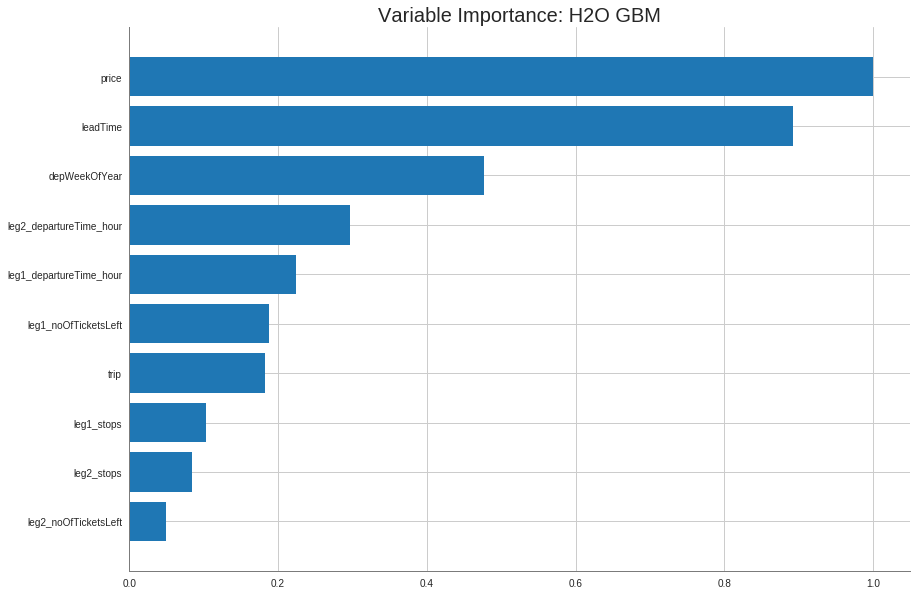

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependencePlot progress: | (cancelled)


H2OJobCancelled: Job<$0301ac11000232d4ffffffff$_9a41b078ff39d64b4ea6060d006490c> was cancelled by the user.

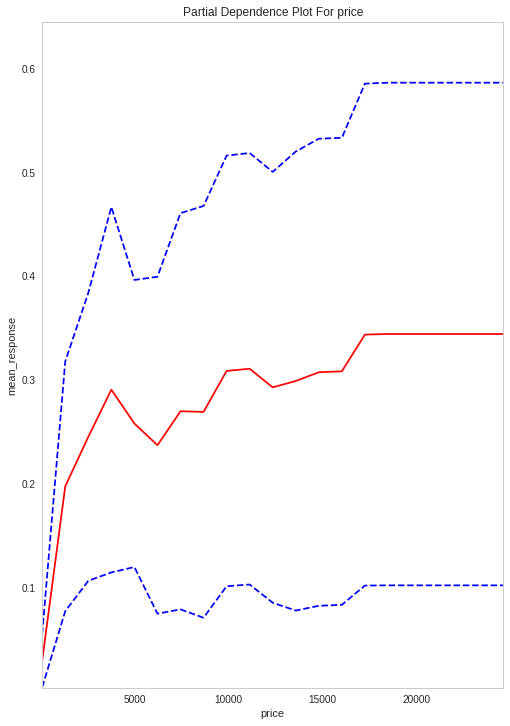

H2O session _sid_9336 closed.


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/shutil.py", line 469, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp99_tz7mh'


In [79]:
# Run AutoML for 30 seconds
# aml = H2OAutoML(max_runtime_secs = 3600)
# aml.train(x=features, y=target,
#           training_frame = train,
#           validation_frame = valid,
#           leaderboard_frame = test)

# # View the AutoML Leaderboard
# lb = aml.leaderboard
# lb
# # # aml.leader    

# aml.leader

# important_features

# hf[important_features]

%time

imp_threshold = 0.01

print("############### Modelling: " + target + " ################")
# model = aml.leader
model = gbm
print(model.confusion_matrix(valid=True))    
model.varimp_plot()   
important_features = [i[0] for i in model.varimp() if i[3]  > imp_threshold]
for f in important_features:        
    if f in ['price',
#              'leg1_carrierSummary_airlineName',
             'depWeekOfYear',
             'leadTime',
#              'leg2_carrierSummary_airlineName',
             'depDayOfWeek',
             'leg1_departureTime_hour',
             'toCity',
             'leg2_departureTime_hour',
             'searchDayOfWeek',
             'leg1_noOfTicketsLeft',
             'leg2_noOfTicketsLeft',
             'fromCity',
             'leg1_stops',
             'trip']:
#             model.partial_plot(data=valid,cols=[f],server=True, plot=True, nbins=272) 
#         else:
        #model.partial_plot(data=test,cols=[f],server=True, plot=True, nbins=21)     #21    
        model.partial_plot(data=hf2,cols=[f],server=True, plot=True, nbins=21)     #21    

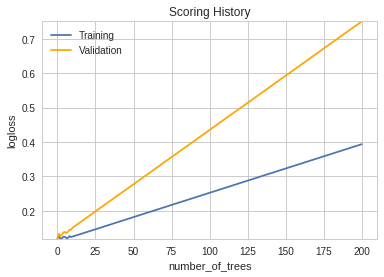

In [78]:
model.plot()

# model.download_mojo(path='D:\\flight.pq.11\\', get_genmodel_jar=True)